# Influence functions for Computer vision

This notebook explores the use of influences functions for convolutional neural networks. First, we will fine-tune Resnet on a (subset) of images taken from the [tiny-imagenet dataset](https://huggingface.co/datasets/Maysee/tiny-imagenet). This dataset was first created for the [Stanford Deep Learning for Computer Vision] (http://cs231n.stanford.edu/) course, and it contains a subset (200 classes vs 1000) and low-resolution version (64x64 pixels vs 256x256) of the images that are in the [original ImageNet dataset](https://image-net.org/challenges/LSVRC/2012/index). 

After training the last layers of the network, we will use pyDVL to find the most and least influential points on the evaluation images. This can be used e.g. to explain errors in the inference of new images or to direct efforts for collecting new data, since it shows possible wholes in data acquisition. Finally, in the last part the notebook also shows that influence functions are an effective tool for finding anomalous or corrupted data points.

Before diving into the code, we will briefly go through the essential theory that is at the foundation of influence functions for neural networks. A more in-depth analysis can be found on the original paper: ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf).
TODO: add theory here

Now that we have looked at the theory, we can proceed with the code! We will start by loading the imports and defining some utility methods to save and load models and influences.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from PIL import Image

import os
import torch
from torch.optim import Adam
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from pydvl.utils.dataset import load_preprocess_imagenet
from pydvl.influence.model_wrappers import TorchModel
from pydvl.influence.general import compute_influences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [3]:
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

## Constants

In [4]:
random_state = 42
is_CI = os.environ.get("CI")

run_model_trainings = True
calculate_influences = True

In [5]:
np.random.seed(random_state)

In [6]:
from pathlib import Path
from cloudpickle import pickle as pkl

imgnet_model_data_path = Path().resolve().parent / "data/imgnet_model"


def save_model(model, train_loss, val_loss, model_name):
    torch.save(model.state_dict(), imgnet_model_data_path / f"{model_name}_weights.pth")
    with open(
        imgnet_model_data_path / f"{model_name}_train_val_loss.pkl", "wb"
    ) as file:
        pkl.dump([train_loss, val_loss], file)


def load_model(model, model_name):
    model.load_state_dict(
        torch.load(imgnet_model_data_path / f"{model_name}_weights.pth")
    )
    with open(
        imgnet_model_data_path / f"{model_name}_train_val_loss.pkl", "rb"
    ) as file:
        train_loss, val_loss = pkl.load(file)
    return train_loss, val_loss


def save_results(results, file_name):
    with open(imgnet_model_data_path / f"{file_name}", "wb") as file:
        pkl.dump(results, file)


def load_results(file_name):
    with open(imgnet_model_data_path / f"{file_name}", "rb") as file:
        results = pkl.load(file)
    return results

We will also here define some plotting methods, which will be used to visualize some of the input images.

In [7]:
def plot_sample_images(
    dataset,
    labels,
    n_images_per_class=3,
    figsize=(8, 8),
):
    plt.rcParams["figure.figsize"] = figsize
    fig, axes = plt.subplots(nrows=n_images_per_class, ncols=len(labels))
    fig.suptitle("Examples of training images")
    for class_idx, class_label in enumerate(labels):
        for img_idx, (_, img_data) in enumerate(
            dataset[dataset["labels"] == class_label].iterrows()
        ):
            axes[img_idx, class_idx].imshow(img_data["images"])
            axes[img_idx, class_idx].axis("off")
            axes[img_idx, class_idx].set_title(f"img label: {class_label}")
            if img_idx + 1 >= n_images_per_class:
                break
    plt.show()


def plot_top_bottom_if_images(
    subset_influences,
    subset_images,
    num_to_plot,
    figsize=(8, 8),
):
    top_if_idxs = np.argsort(subset_influences)[-num_to_plot:]
    bottom_if_idxs = np.argsort(subset_influences)[:num_to_plot]

    fig, axes = plt.subplots(nrows=num_to_plot, ncols=2)
    plt.rcParams["figure.figsize"] = figsize
    fig.suptitle("Botton (left) and top (right) influences")

    for plt_idx, img_idx in enumerate(bottom_if_idxs):
        axes[plt_idx, 0].set_title(f"img influence: {subset_influences[img_idx]:0f}")
        axes[plt_idx, 0].imshow(subset_images[img_idx])
        axes[plt_idx, 0].axis("off")

    for plt_idx, img_idx in enumerate(top_if_idxs):
        axes[plt_idx, 1].set_title(f"img influence: {subset_influences[img_idx]:0f}")
        axes[plt_idx, 1].imshow(subset_images[img_idx])
        axes[plt_idx, 1].axis("off")

    plt.show()

## Loading and preprocessing the dataset

The dataset is loaded through the load_preprocess_imagenet method. We will load the images related to the classes 90 and 100. This is an arbitrary choice and any other class would have worked. You can try selecting any other set of numbers, even more than just two (you could even select all 200 classes, though this will require longer training times).

In [8]:
labels_to_keep = [90, 100]
train_ds, val_ds, test_ds = load_preprocess_imagenet(
    train_size=0.8,
    test_size=0.1,
    keep_labels=labels_to_keep,
    is_CI=is_CI,
)

Using custom data configuration Maysee--tiny-imagenet-35af7c46a941f08e
Found cached dataset parquet (/Users/fabio/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-da97d9664ceeb173.arrow
Loading cached split indices for dataset at /Users/fabio/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b21bf9a888e302de.arrow and /Users/fabio/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e9184dfd40a5cf7b.arrow
Loading cached split indices for dataset at /Users/fabi

Now that we have loaded the data, let's take a look at a sample of the images

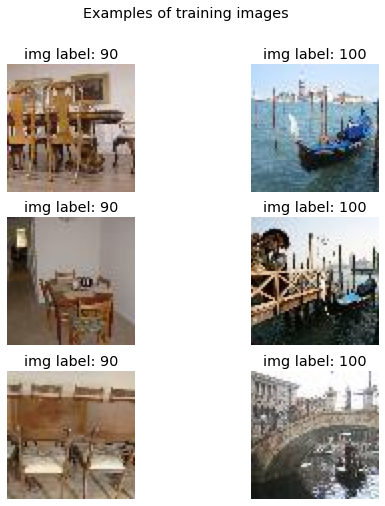

In [9]:
plot_sample_images(train_ds, labels_to_keep, n_images_per_class=3)

The first class is related to dining tables, the second to boats and to Venice! Let's now further pre-process the data and prepare for model training

In [10]:
ds_label_to_model_label = {ds_label: idx for idx, ds_label in enumerate(labels_to_keep)}
model_label_to_ds_label = {idx: ds_label for idx, ds_label in enumerate(labels_to_keep)}


def get_model_io(x, y):
    x_nn = torch.stack(x.tolist())
    y_nn = [ds_label_to_model_label[yi] for yi in y]
    return x_nn, y_nn


ce_loss = nn.CrossEntropyLoss()

train_x, train_y = get_model_io(train_ds["normalized_images"], train_ds["labels"])
val_x, val_y = get_model_io(val_ds["normalized_images"], val_ds["labels"])
test_x, test_y = get_model_io(test_ds["normalized_images"], test_ds["labels"])

## Model definition

In this part we will proceed with the initialization of the model and of some helper methods for training and evaluation. 

The model is defined by loading resnet18 and then switching the last few layers so that we can do binary classification on our selected classes.

In [11]:
def initialize_model(output_size):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    # Finetune Final few layers to adjust for tiny imagenet input
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, output_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


model_ft = initialize_model(output_size=len(labels_to_keep))

Training is done through some pytorch convenience wrappers (TorchModel) which are part of pyDVL.

In [12]:
def train_model(model, num_epochs, training_data, lr=0.001):
    optimizer = Adam(model.parameters(), lr=lr)

    get_model_io(training_data["normalized_images"], training_data["labels"])
    train_x, train_y = get_model_io(
        training_data["normalized_images"], training_data["labels"]
    )

    train_loss, val_loss = TorchModel(model=model).fit(
        x_train=train_x,
        y_train=train_y,
        x_val=val_x,
        y_val=val_y,
        loss=ce_loss,
        optimizer=optimizer,
        num_epochs=num_epochs,
        batch_size=1000,
    )
    return train_loss, val_loss


def plot_train_val_loss(train_loss, val_loss, figsize=(10, 8)):
    plt.rcParams["figure.figsize"] = figsize
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.legend()
    plt.show()


def get_f1_score_on_test_set(model):
    pred_y_test = np.argmax(model(test_x).detach(), axis=1)
    return f1_score(test_y, pred_y_test, average="weighted")

## Model training and influence computation

We will train the model for 50 epochs and save the results. Then we will plot the train and validation loss curves.

In [13]:
if run_model_trainings:
    num_epochs = 50
    train_loss, val_loss = train_model(
        model_ft, num_epochs=num_epochs, training_data=train_ds
    )
    save_model(model_ft, train_loss, val_loss, model_name="model_ft")
else:
    train_loss, val_loss = load_model(model_ft, model_name="model_ft")

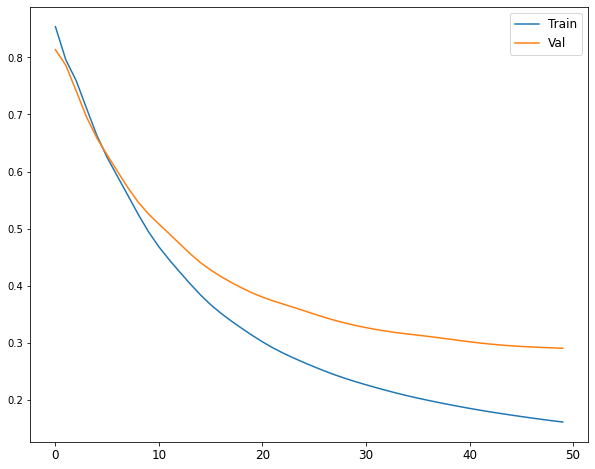

In [14]:
plot_train_val_loss(train_loss, val_loss)

Confusion matrix and f1 score are good, especially considering the low resolution of the images and their complexity (large diversity of objects)

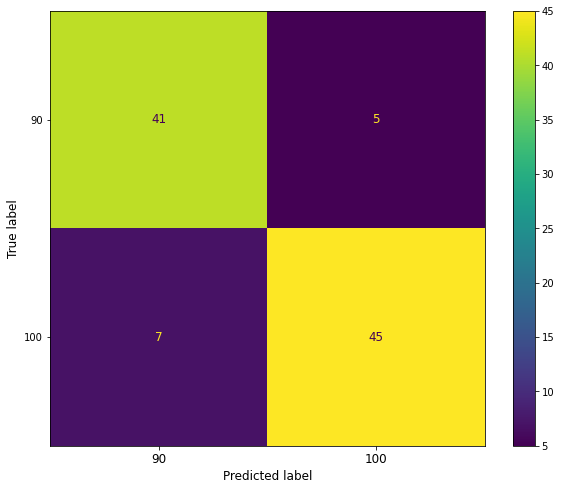

In [15]:
pred_y_test = np.argmax(model_ft(test_x).detach(), axis=1)

cm = confusion_matrix(test_y, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_keep)
disp.plot();

In [16]:
f1_score(test_y, pred_y_test, average="weighted")

0.8776531889351485

And now let's calculate influences. The method compute_influences will take the trained model, a loss (which typically is the training loss, but not necessarily), some input dataset with labels (which typically are the training data, or a subset of it) and some test data (which in this case will be the validation set). 

Other important parameters are the hessian regularization term, which should be chosen as small as possible for the computation to converge. Details on why this is important can be found in the pyDVL documentation or in the [original paper](https://arxiv.org/pdf/1703.04730.pdf). 

Since the Resnet18 is quite big, the inversion methods that should be preferred is conjugate gradient ("cg"). The direct method would require a lot of memory. Finally, the influence type will be "up" (the other option, "perturbation", is beyond the scope of this notebook, but more info can be found in the influence_wine notebook or on the pyDVL documentation).

The output of calculate_influences is a matrix of size (validation_set_length, training_set_length). Each row represents a validation data-point, and each column a training data-point. Each entry (i,j) represents the influence of training point j on the validation point i.

In [17]:
if calculate_influences:
    influences = compute_influences(
        model=model_ft,
        loss=ce_loss,
        x=train_x,
        y=train_y,
        x_test=val_x,
        y_test=val_y,
        hessian_regularization=1e-3,
        inversion_method="cg",
        influence_type="up",
    )
    save_results(influences, file_name="influences.pkl")
else:
    influences = load_results(file_name="influences.pkl")

## Analysing the influence on validation images

Let's take an image in the validation set. Among the images in the training set, we will take those that have the same label and visualize those that have the highest and lowest influence. 

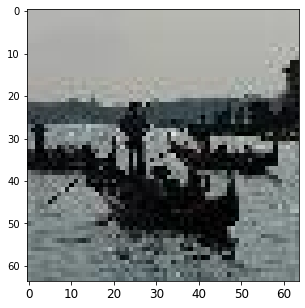

In [202]:
val_image_idx = 118
plt.rcParams["figure.figsize"] = (5, 5)
plt.imshow(val_ds["images"][val_image_idx])

In [203]:
print(
    "Predicted label:",
    model_label_to_ds_label[
        np.argmax(model_ft(val_x[val_image_idx].unsqueeze(0)).detach(), axis=1).item()
    ],
)
print("Real label:", val_ds["labels"][val_image_idx])

Predicted label: 90
Real label: 100


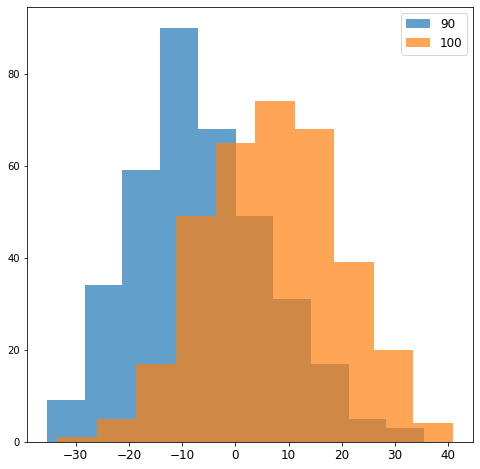

In [204]:
plt.rcParams["figure.figsize"] = (8, 8)
for label in labels_to_keep:
    plt.hist(
        influences[val_image_idx][train_ds["labels"] == label], label=label, alpha=0.7
    )
plt.legend()
plt.show()

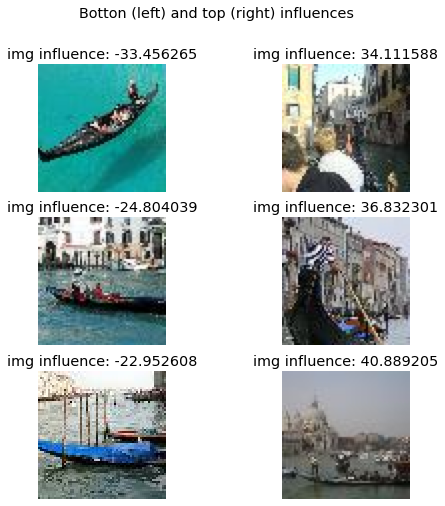

In [205]:
images_with_same_label = train_ds["labels"] == val_ds["labels"][val_image_idx]
if_same_label = influences[val_image_idx][images_with_same_label]
imges_same_label = train_ds["images"][images_with_same_label].values
plot_top_bottom_if_images(if_same_label, subset_images=imges_same_label, num_to_plot=3)

In [22]:
avg_influences = np.mean(influences, axis=0)

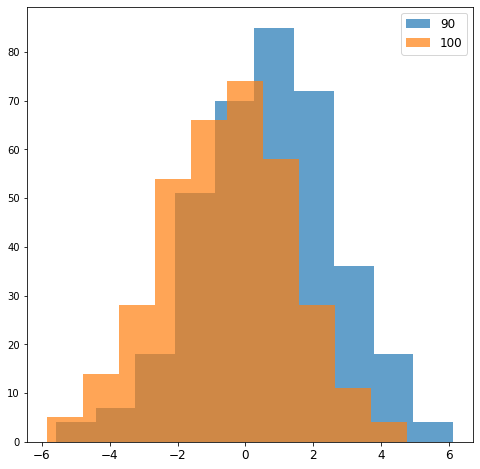

In [206]:
plt.rcParams["figure.figsize"] = (8, 8)
for label in labels_to_keep:
    plt.hist(avg_influences[train_ds["labels"] == label], label=label, alpha=0.7)
plt.legend()
plt.show()

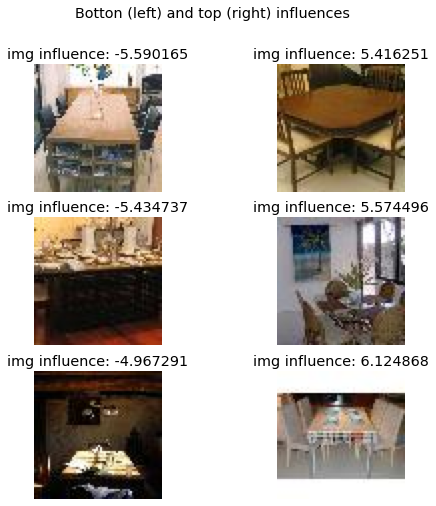

In [24]:
label = 90
img_with_selected_label = train_ds["labels"] == label
if_selected_label = avg_influences[img_with_selected_label]
imges_same_label = train_ds["images"][img_with_selected_label].values
plot_top_bottom_if_images(if_selected_label, imges_same_label, num_to_plot=3)

## Calculating the influence of corrupted training data

In [101]:
def get_corrupted_dataset(dataset, fraction_to_corrupt, avg_influences):
    indices_to_corrupt = []
    corrupted_dataset = deepcopy(dataset)
    corrupted_indices = {l: [] for l in labels_to_keep}

    avg_influences_series = pd.DataFrame()
    avg_influences_series["avg_influences"] = avg_influences
    avg_influences_series["labels"] = dataset["labels"]

    for label in labels_to_keep:
        class_data = avg_influences_series[avg_influences_series["labels"] == label]
        num_corrupt = int(fraction_to_corrupt * len(class_data))
        indices_to_corrupt = class_data.nlargest(
            num_corrupt, "avg_influences"
        ).index.tolist()
        wrong_labels = [l for l in labels_to_keep if l != label]
        for img_idx in indices_to_corrupt:
            sample_label = np.random.choice(wrong_labels)
            corrupted_dataset.at[img_idx, "labels"] = sample_label
            corrupted_indices[sample_label].append(img_idx)
    return corrupted_dataset, corrupted_indices


def plot_influence_distribution(
    corrupted_dataset, corrupted_indices, avg_corrupted_influences, figsize=(16, 8)
):
    plt.rcParams["figure.figsize"] = figsize
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle("Distribution of corrupted and clean influences.")
    avg_label_influence = pd.DataFrame(
        columns=["label", "avg_non_corrupted_infl", "avg_corrupted_infl"]
    )
    for idx, label in enumerate(labels_to_keep):
        avg_influences_series = pd.Series(avg_corrupted_influences)
        class_influences = avg_influences_series[corrupted_dataset["labels"] == label]
        corrupted_infl = class_influences[
            class_influences.index.isin(corrupted_indices[label])
        ]
        non_corrupted_infl = class_influences[
            ~class_influences.index.isin(corrupted_indices[label])
        ]
        avg_label_influence.loc[idx] = [
            label,
            np.mean(non_corrupted_infl),
            np.mean(corrupted_infl),
        ]
        axes[idx].hist(
            non_corrupted_infl, label="non corrupted data", density=True, alpha=0.7
        )
        axes[idx].hist(corrupted_infl, label="corrupted data", density=True, alpha=0.7)
        axes[idx].set_xlabel("influence values")
        axes[idx].set_ylabel("Points distribution")
        axes[idx].set_title(f"influences for {label=}")
        axes[idx].legend()
    plt.show()
    return avg_label_influence.astype({"label": "int32"})

In [26]:
model_corrupted = initialize_model(output_size=len(labels_to_keep))
corrupted_dataset, corrupted_indices = get_corrupted_dataset(
    dataset=train_ds,
    fraction_to_corrupt=0.1,
    avg_influences=avg_influences,
)

if run_model_trainings:
    num_epochs = 50
    train_loss, val_loss = train_model(
        model_corrupted,
        num_epochs=num_epochs,
        training_data=corrupted_dataset,
    )
    save_model(model_corrupted, train_loss, val_loss, model_name="model_corrupted")
else:
    train_loss, val_loss = load_model(model_corrupted, model_name="model_corrupted")

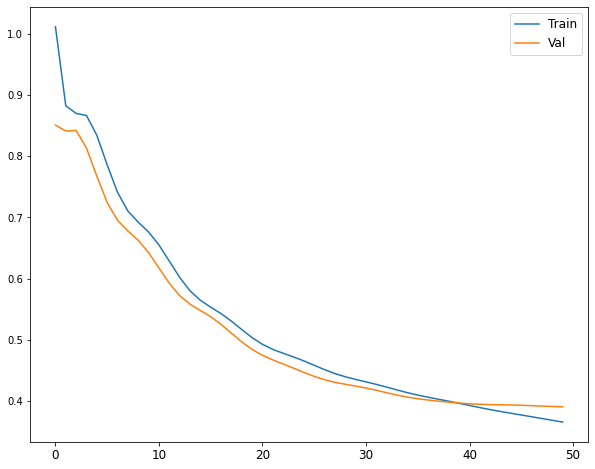

In [27]:
plot_train_val_loss(train_loss, val_loss)

In [28]:
model_score = get_f1_score_on_test_set(model_corrupted)
print(model_score)

0.8062236482441394


In [29]:
if calculate_influences:
    corrupted_train_x, corrupted_train_y = get_model_io(
        corrupted_dataset["normalized_images"],
        corrupted_dataset["labels"],
    )
    influences = compute_influences(
        model=model_corrupted,
        loss=ce_loss,
        x=corrupted_train_x,
        y=corrupted_train_y,
        x_test=val_x,
        y_test=val_y,
        hessian_regularization=1e-3,
        inversion_method="cg",
        influence_type="up",
    )
    save_results(influences, file_name="influences_corrupted.pkl")
else:
    influences = load_results(file_name="influences_corrupted.pkl")

In [30]:
avg_corrupted_influences = np.mean(influences, axis=0)

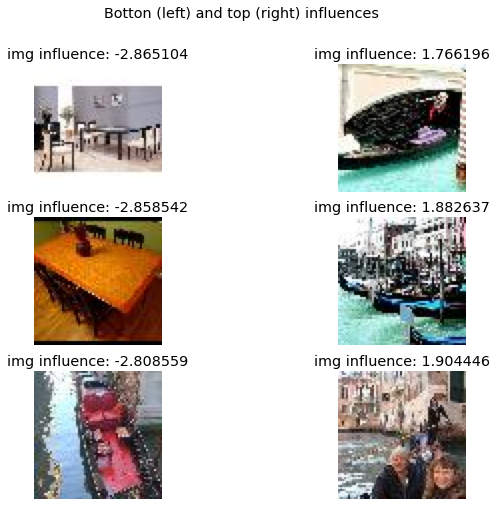

In [31]:
label = 100
img_with_selected_label = corrupted_dataset["labels"] == label
if_selected_label = avg_corrupted_influences[img_with_selected_label]
imges_same_label = corrupted_dataset["images"][img_with_selected_label].values
plot_top_bottom_if_images(if_selected_label, imges_same_label, num_to_plot=3)

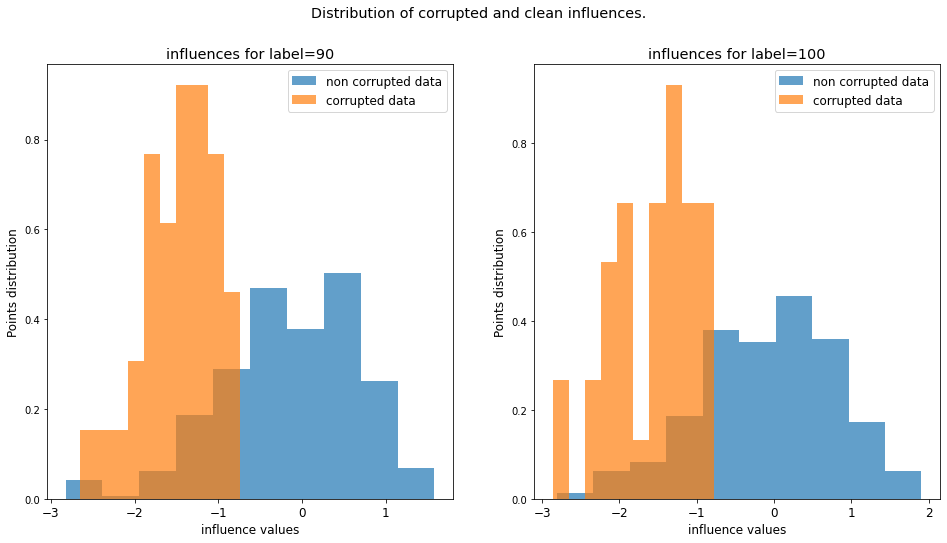

In [102]:
avg_label_influence = plot_influence_distribution(
    corrupted_dataset, corrupted_indices, avg_corrupted_influences
)

In [103]:
avg_label_influence

,label,avg_non_corrupted_infl,avg_corrupted_infl
0,90,-0.134924,-1.477618
1,100,-0.084978,-1.574276
